## Prueba 2 - Machine Learning
* Nombre: Pablo Bustamante - Melissa Neira
* Profesor: Gabriel Tamayo
* Generación: G12

----
### Sesión Presencial 2

* Al final de la sesión, el alumno (o pareja) debe completar el punto de Análisis Exploratorio e iniciar el proceso de Feature engineering.
* Elementos comunes a considerar en  este hito:
    * Se debe analizar el comportamiento del vector objetivo. (2 puntos)
    * Se debe reportar el patrón de datos perdidos. (1 punto)
    * Se debe implementar recodificaciones para el vector objetivo. (2 puntos)
* Específicos prueba 2:
    * Definir el tipo de modelo a implementar para generar una predicción de arresto, así como su grilla de hiperparámetros.
    * Definir la recodificación del vector objetivo para generar una predicción de acción violenta en el procedimiento.
    * Implementar el script preproc_nyc_sqf.py para igualar la cantidad de atributos en el benchmark.
----

### Un análisis exploratorio

En el siguiente apartado harémos la importación del dataframe utilizando la libreria pandas y posteriormente analizaremos sus features para identificar que tipo de dato contiene.


Además se identificarán los valores perdidos que tenga y si es necesario elimiarlos o recodificar u 
reestructurar parte de la data.


Luego se hará una breve revisión de sus comportamientos univa y multi variados para identificar futuras 
normalizaciones, regularizaciones, escalamientos, etc. (preprocesamiento en general).


In [1]:
#Manipulacion de datos
import pandas as pd
import numpy as np

#Graficacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgn

#Preprocesamiento de data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
import spacy


#Extras para experiencia de usuario
import warnings
warnings.filterwarnings('ignore')

import preproc_nyc_sqf as pp

**Se debe analizar el comportamiento del vector objetivo. (2 puntos)**

### Análisis exploratorio

Identificamos que tenemos dos dataset que coinciden en sus columnas y difieren en el periodo (año) así que los uniremos para poder trabajar de manera que cometamos menos errores al manipular la data.

In [2]:
df_a = pd.read_csv('2009_1perc.csv').drop(columns='Unnamed: 0')
df_b = pd.read_csv('2010_1perc.csv').drop(columns='Unnamed: 0')
df_union = [df_a, df_b]
df = pd.concat(df_union).reset_index().drop(columns='index')

Imprimiremos la cantiadad de registros/columnas antes y despues de la union para ver que todo coincida

In [3]:
print(f'Filas data 2009:  {df_a.shape[0]} Columnas data 2009: {df_a.shape[1]}')
print(f'Filas data 2010: {df_b.shape[0]} Columnas data 2010: {df_b.shape[1]}')
print(f'Filas data unida: {df.shape[0]} Columnas data unida: {df.shape[1]}')

Filas data 2009:  5812 Columnas data 2009: 111
Filas data 2010: 6013 Columnas data 2010: 111
Filas data unida: 11825 Columnas data unida: 111


mostraremos los primeros registros para ver de reojo que datos contiene el primer dataset

In [4]:
df.head(2)

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0  2009   41     1779   4032009       130       A     O       P     1.0   
1  2009  108     5805  10292009      1050       A     O       P     3.0   

  crimsusp  ...  zip addrpct sector beat post   xcoord   ycoord dettypcm  \
0      CPW  ...           41      G    7       1013067  0238633       CM   
1     BURG  ...          108      J            1012043  0212157       CM   

   linecm  detailcm  
0       1        20  
1       1        14  

[2 rows x 111 columns]

Lo mismo para los ultimos registros y ver que tiene el segundo dataset

In [5]:
df.tail(2)

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
11823  2010  115    13122  11232010      2100       1     O       P     1.0   
11824  2010   14      219   1062010      1406       1     I       T     4.0   

        crimsusp  ...  zip addrpct sector beat post   xcoord  ycoord dettypcm  \
11823     FELONY  ...          115      E            1014722  214388       CM   
11824  CRIM MIS.  ...           14      H   11        987078  215157       CM   

       linecm  detailcm  
11823       1        85  
11824       1        23  

[2 rows x 111 columns]

Podemos apreciar que el dataframe contiene muchos features asociados a interrogaciones e investigaciones asociadas por el departamento de policias de nueva york en la vía publica

A continuación veremos los nombres y tipos de datos de cada feature (columna)

In [6]:
df.info(verbose=True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11825 entries, 0 to 11824
Data columns (total 111 columns):
 #   Column    Dtype  
---  ------    -----  
 0   year      int64  
 1   pct       int64  
 2   ser_num   int64  
 3   datestop  int64  
 4   timestop  int64  
 5   recstat   object 
 6   inout     object 
 7   trhsloc   object 
 8   perobs    float64
 9   crimsusp  object 
 10  perstop   int64  
 11  typeofid  object 
 12  explnstp  object 
 13  othpers   object 
 14  arstmade  object 
 15  arstoffn  object 
 16  sumissue  object 
 17  sumoffen  object 
 18  compyear  int64  
 19  comppct   int64  
 20  offunif   object 
 21  officrid  object 
 22  frisked   object 
 23  searched  object 
 24  contrabn  object 
 25  adtlrept  object 
 26  pistol    object 
 27  riflshot  object 
 28  asltweap  object 
 29  knifcuti  object 
 30  machgun   object 
 31  othrweap  object 
 32  pf_hands  object 
 33  pf_wall   object 
 34  pf_grnd   object 
 35  pf_drwep  object 
 36  pf_ptwep  o

Se puede apreciar que hay
* 1 columna float
* 15 columnas int64
* 95 columnas object

Observaremos cuantos valores perdidos tenemos, para ello haremos un pequeño cambio donde asignaremos como valores perdidos aquellos casos donde los individuis tienen mas de 18 y menos de 100 años, dado que esos datos los excluiremos del dataframe.

In [7]:
df['valores_perdidos'] = np.where(np.logical_and(df['age'] > 18, df['age'] < 100), df['age'], np.nan)
df['valores_perdidos_porcentaje'] = np.where(np.logical_and(df['age'] > 18, df['age'] < 100), df['age'], 'PERDIDOS')

In [8]:
valores_perdidos=df['valores_perdidos_porcentaje'].value_counts('%').max()
print(f'la cantidad de valores perdidos corresponde al {round(valores_perdidos,2)}%')

la cantidad de valores perdidos corresponde al 0.21%


De manera mas visual los datos perdidos se representan así

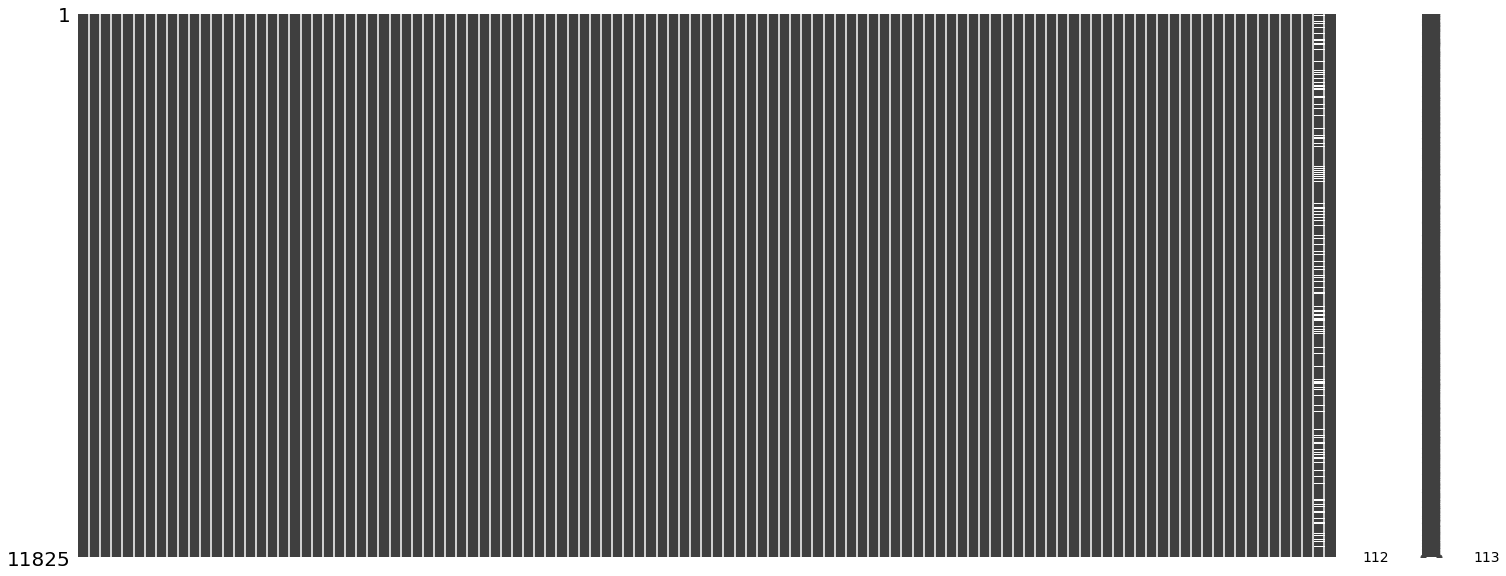

In [9]:
msgn.matrix(df);

Vamos a aplicar la instrucción del enunciado de la prueba para reducir los features del dataframe y a la vez separar las variables continuas de las discretas

In [10]:
df,categoricals,numerics=pp.create_suitable_dataframe(df)

['year', 'pct', 'ser_num', 'datestop', 'timestop', 'perstop', 'compyear', 'comppct', 'repcmd', 'revcmd', 'dob', 'age', 'ht_feet', 'ht_inch', 'weight', 'perobs', 'valores_perdidos']


In [11]:
df.info(verbose=True);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9383 entries, 0 to 11824
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recstat                      9383 non-null   object 
 1   inout                        9383 non-null   object 
 2   trhsloc                      9383 non-null   object 
 3   typeofid                     9383 non-null   object 
 4   explnstp                     9383 non-null   object 
 5   othpers                      9383 non-null   object 
 6   arstmade                     9383 non-null   object 
 7   sumissue                     9383 non-null   object 
 8   offunif                      9383 non-null   object 
 9   officrid                     9383 non-null   object 
 10  frisked                      9383 non-null   object 
 11  searched                     9383 non-null   object 
 12  contrabn                     9383 non-null   object 
 13  pistol           

A continuación crearemos una funcion para poder graficar las variables de forma mas interpretable a simple vista e identificar sus comportamientos

Para ello separaremos en listas los tipos de variables

In [12]:
def graficar_variables(df: pd.DataFrame, var: str, type=1) -> None:
    """
    Grafica una variable categórica de un DataFrame.
    Aparecerá un Gráfico de barras cuando estemos frente a una variable binaria o categórica.
    Parameters
    ----------
    :param df: DataFrame
    :param var: Se debe ingresar la columna a graficar
    :return : None
    -------
    Se grafica la columna indicada.
    """
    assert type != 1 or type != 0 or type != 2

    if type == 0:
        sns.countplot(df[var])
    if type == 1:
        try:
            sns.distplot(df[var])
        except Exception:
            try:
                plt.hist(df[var])
            except:
                sns.countplot(df[var])
    else:
        try:
            sns.boxplot(data=df,y=var)
        except Exception:
            plt.hist(df[var])
    plt.title(var)
    plt.tight_layout()

In [13]:
object_data_type = pp.infer_datatype(df, 'object')
integer_data_type = pp.infer_datatype(df, 'int')
float_data_type = pp.infer_datatype(df, 'float')

numerics=list(integer_data_type) + list(float_data_type)

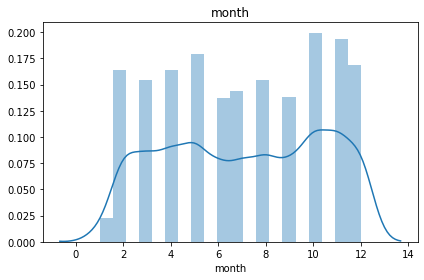

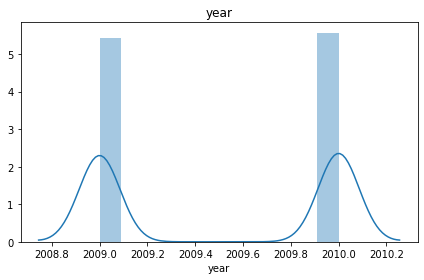

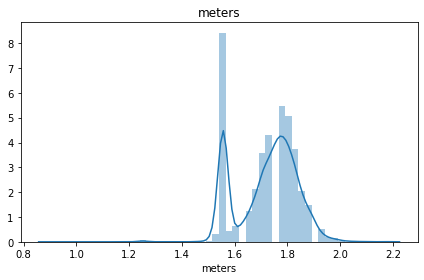

In [14]:
for i in numerics:
    graficar_variables(df,i,1)
    plt.show()

A continuación analizaremos el comportamiento de nuestro vector objetivo, el cual en este caso es 
'arstmade'

In [15]:
df['arstmade'].value_counts('%')

N    0.93712
Y    0.06288
Name: arstmade, dtype: float64

Recodificaremos el vector de arrestos para tener un binario y así utilizarlo de manera mas comoda en el modelo

In [16]:
df['arstmade']=(df['arstmade'].str.contains('Y')).astype(int)

Podemos apreciar que el 6,2% de los casos terminan en arrestos.
Graficado se vería de la siguiente manera:

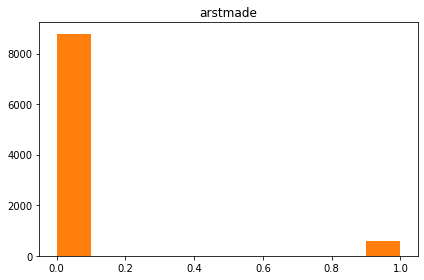

In [17]:
graficar_variables(df,'arstmade',1)
plt.show()

In [18]:
df['hubo_violencia']=(df['pf_hands'].str.contains('Y') | df['pf_wall'].str.contains('Y') | df['pf_grnd'].str.contains('Y') | df['pf_drwep'].str.contains('Y') | df['pf_baton'].str.contains('Y') | df['pf_hcuff'].str.contains('Y') | df['pf_pepsp'].str.contains('Y') | df['pf_other'].str.contains('Y')).astype(int)

In [19]:
df['hubo_violencia'].value_counts('%')

0    0.761697
1    0.238303
Name: hubo_violencia, dtype: float64

Al recodificar el nuevo vector objetivo para saber si hubo arresto o no, podemos inferir que hubo violencia en el 26% de los casos

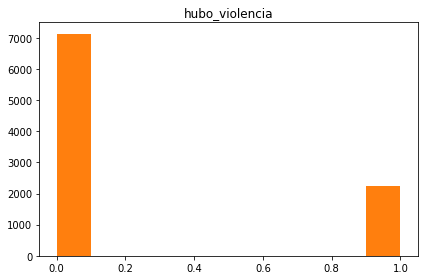

In [20]:
graficar_variables(df,'hubo_violencia',1)
plt.show()

Para graficar el arresto vamos a ocupar el:
* Bayes Ingenuo

Para graficar si el arresto culminará en una en un hecho violento o no, utilizaremos:
* Regresion Ridge
* Regresion Lasso
* Regresion ElasticNet
* Arboles de desicion
* Random Forest
* SVM
* Boosting Machine
* Gradient Boosting
* GAM 
* (Si alcanzamos Red Neuronal)